In [ ]:
import json, re, string
import pandas as pd
import nltk
nltk.download("stopwords")
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
!pip install PySastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory as SF
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
from pprint import pprint
import numpy as np
import tqdm

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [ ]:
df = pd.read_csv("bola_news.csv")
df

,Unnamed: 0,title
0,0,Ikatan Suporter dalam Unsur Primordialisme
1,1,"Timnas U20 Indonesia Punya Banyak PR, Shin Tae..."
2,2,PDFI Jawa Timur Turun Langsung Tangani Otopsi ...
3,3,"Jadwal Siaran Langsung Hylo Open 2022, 3 Wakil..."
4,4,"Terpilih Secara Aklamasi, Ahmad Sahroni Jadi K..."
...,...,...
130,130,Suzuki Menuju Perpisahan di MotoGP Valencia: A...
131,131,Bintang Asing Persib Dukung Jepang meski Berad...
132,132,"Real Sociedad Vs Man United, Pesan Ronaldo Tak..."
133,133,"Hasil Hylo Open 2022: Menang dalam 34 Menit, R..."


In [ ]:
def case_folding(data):
    data = data.lower()
    data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data).split())
    data = re.sub(r"\d+", "", data)
    data = data.translate(str.maketrans("","",string.punctuation))
    data = re.sub(r"\n","",data)
    data = re.sub(r"\t","",data)
    return data

In [ ]:
def stopword_cleaner(data):
    sw_indonesia = stopwords.words("indonesian")
    sw_indonesia = set(sw_indonesia)
    data  = [word for word in data if word not in sw_indonesia]
    data = ''.join(data)
    return data

In [ ]:
df['title_clean'] = df['title'].apply(case_folding)
df

,Unnamed: 0,title,title_clean
0,0,Ikatan Suporter dalam Unsur Primordialisme,ikatan suporter dalam unsur primordialisme
1,1,"Timnas U20 Indonesia Punya Banyak PR, Shin Tae...",timnas u indonesia punya banyak pr shin tae yo...
2,2,PDFI Jawa Timur Turun Langsung Tangani Otopsi ...,pdfi jawa timur turun langsung tangani otopsi ...
3,3,"Jadwal Siaran Langsung Hylo Open 2022, 3 Wakil...",jadwal siaran langsung hylo open wakil indon...
4,4,"Terpilih Secara Aklamasi, Ahmad Sahroni Jadi K...",terpilih secara aklamasi ahmad sahroni jadi ke...
...,...,...,...
130,130,Suzuki Menuju Perpisahan di MotoGP Valencia: A...,suzuki menuju perpisahan di motogp valencia ak...
131,131,Bintang Asing Persib Dukung Jepang meski Berad...,bintang asing persib dukung jepang meski berad...
132,132,"Real Sociedad Vs Man United, Pesan Ronaldo Tak...",real sociedad vs man united pesan ronaldo tak ...
133,133,"Hasil Hylo Open 2022: Menang dalam 34 Menit, R...",hasil hylo open menang dalam menit rinov pit...


In [ ]:
df['title_clean'] = df['title_clean'].apply(stopword_cleaner)
df

,Unnamed: 0,title,title_clean
0,0,Ikatan Suporter dalam Unsur Primordialisme,ikatan suporter dalam unsur primordialisme
1,1,"Timnas U20 Indonesia Punya Banyak PR, Shin Tae...",timnas u indonesia punya banyak pr shin tae yo...
2,2,PDFI Jawa Timur Turun Langsung Tangani Otopsi ...,pdfi jawa timur turun langsung tangani otopsi ...
3,3,"Jadwal Siaran Langsung Hylo Open 2022, 3 Wakil...",jadwal siaran langsung hylo open wakil indon...
4,4,"Terpilih Secara Aklamasi, Ahmad Sahroni Jadi K...",terpilih secara aklamasi ahmad sahroni jadi ke...
...,...,...,...
130,130,Suzuki Menuju Perpisahan di MotoGP Valencia: A...,suzuki menuju perpisahan di motogp valencia ak...
131,131,Bintang Asing Persib Dukung Jepang meski Berad...,bintang asing persib dukung jepang meski berad...
132,132,"Real Sociedad Vs Man United, Pesan Ronaldo Tak...",real sociedad vs man united pesan ronaldo tak ...
133,133,"Hasil Hylo Open 2022: Menang dalam 34 Menit, R...",hasil hylo open menang dalam menit rinov pit...


In [ ]:
df_split = [i.split() for i in df["title_clean"]]
df_split

In [ ]:
dictionary = corpora.Dictionary(df_split)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df_split]

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )

In [ ]:
pprint(ldamodel.print_topics())

[(0,
  '0.023*"vs" + 0.020*"grup" + 0.018*"merah" + 0.017*"open" + 0.016*"zurich" + '
  '0.015*"united" + 0.013*"man" + 0.013*"persib" + 0.013*"head" + 0.013*"di"'),
 (1,
  '0.031*"motogp" + 0.029*"valencia" + 0.025*"dengan" + 0.016*"wib" + '
  '0.015*"link" + 0.015*"live" + 0.015*"streaming" + 0.015*"kickoff" + '
  '0.013*"champions" + 0.012*"bagnaia"'),
 (2,
  '0.024*"hasil" + 0.024*"di" + 0.022*"hylo" + 0.022*"open" + 0.021*"vs" + '
  '0.019*"man" + 0.018*"real" + 0.014*"sociedad" + 0.013*"dunia" + '
  '0.013*"united"'),
 (3,
  '0.035*"hylo" + 0.034*"open" + 0.028*"dunia" + 0.024*"piala" + '
  '0.021*"ginting" + 0.019*"di" + 0.019*"hasil" + 0.017*"ke" + 0.016*"besar" + '
  '0.015*"final"'),
 (4,
  '0.032*"dan" + 0.020*"vs" + 0.016*"liga" + 0.016*"lolos" + 0.014*"kata" + '
  '0.013*"hati" + 0.012*"pensiun" + 0.011*"roma" + 0.011*"di" + '
  '0.010*"united"')]


In [ ]:
#coherence value
coherence_model_lda = CoherenceModel(model=ldamodel, texts=df_split, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4313118065610725


In [ ]:
# fungsi hyper tunning paramaeter
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_split, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# Topics range
min_topics = 2
max_topics = 5
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()
 

  0%|          | 0/540 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
 33%|███▎      | 180/540 [02:55<05:51,  1.03it/s]


In [ ]:
df_tuning_result = pd.read_csv("lda_tuning_results.csv")
display(df_tuning_result)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.437333
1,75% Corpus,2,0.01,0.31,0.440035
2,75% Corpus,2,0.01,0.61,0.442967
3,75% Corpus,2,0.01,0.9099999999999999,0.432191
4,75% Corpus,2,0.01,symmetric,0.436100
...,...,...,...,...,...
175,100% Corpus,4,asymmetric,0.01,0.435741
176,100% Corpus,4,asymmetric,0.31,0.357033
177,100% Corpus,4,asymmetric,0.61,0.367270
178,100% Corpus,4,asymmetric,0.9099999999999999,0.368917


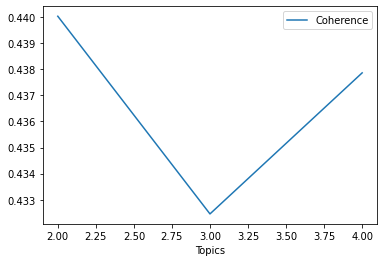

In [ ]:
df_plot = df_tuning_result[(df_tuning_result.Alpha == "0.01") & (df_tuning_result.Beta == "0.31") & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot.plot(x='Topics', y = "Coherence", kind="line")

In [ ]:
df_plot_2 = df_tuning_result[(df_tuning_result.Topics == 2) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
92,100% Corpus,2,0.01,0.61,0.442967
91,100% Corpus,2,0.01,0.31,0.440035
90,100% Corpus,2,0.01,0.01,0.437333
94,100% Corpus,2,0.01,symmetric,0.436100
93,100% Corpus,2,0.01,0.9099999999999999,0.432191
104,100% Corpus,2,0.61,symmetric,0.412413
114,100% Corpus,2,symmetric,symmetric,0.411726
97,100% Corpus,2,0.31,0.61,0.411726
112,100% Corpus,2,symmetric,0.61,0.411726
98,100% Corpus,2,0.31,0.9099999999999999,0.411726


In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
LDAvis_prepared

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.102754  0.111252       1        1  24.847601
1      0.139914  0.084394       2        1  24.084165
2     -0.135554 -0.071186       3        1  20.370034
0      0.014526 -0.005946       4        1  19.683726
4      0.083868 -0.118513       5        1  11.014474, topic_info=         Term       Freq      Total Category  logprob  loglift
46     motogp  10.000000  10.000000  Default  30.0000  30.0000
50   valencia   9.000000   9.000000  Default  29.0000  29.0000
412       dan   9.000000   9.000000  Default  28.0000  28.0000
28       hylo  19.000000  19.000000  Default  27.0000  27.0000
57      dunia  13.000000  13.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
381      real   1.118201   6.362904   Topic5  -4.8601   0.4672
235      pssi   1.055223   2.609373   Topic5  -4.9181   1.3006
90       dari   1.054951   5.586586   Topic5  -4.9183   0.5391
263   ronaldo   1.053912   3.881574   Topic5  -4.9193   0.9022
548    menuju   1.052917   3.169842   Topic5  -4.9203   1.1038

[264 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
177       4  0.583069       ada
604       1  0.905430  adaptasi
300       1  0.297096      akan
300       2  0.594192      akan
385       3  0.948519    ambisi
...     ...       ...       ...
172       2  0.885077       wib
139       3  0.575434      yang
139       4  0.287717      yang
307       4  0.583197       yew
493       4  0.859785    zurich

[268 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])